In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
#get working directory path
wd = os.getcwd()
#load in training data and labels as dataframe
trainDF = pd.read_csv(wd + '/training.csv')

In [3]:
#remove observations with velocity less than 80
trainDF = trainDF.drop(trainDF[trainDF.Velo < 80].index).reset_index()

In [4]:
train_data = trainDF[['Velo','SpinRate','HorzBreak','InducedVertBreak']]#.to_numpy()
train_labels = trainDF[['InPlay']]#.to_numpy()

In [5]:
#try out a base model - decision tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [6]:
#create training and validation sets 
#validation set is for hyperparameter tuning
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.30, random_state=5)

In [7]:
#--------USE A PIPELINE------------
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

In [8]:
numeric_features = ['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak']

#replace missing values with median and standardize features
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='median')),
       ('scaler', StandardScaler())
])

#preprocessor contains numeric transformer
preprocessor = ColumnTransformer(
    transformers=[ ('numeric', numeric_transformer, numeric_features)]
) 

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        #('classifier', DecisionTreeClassifier())
        #('classifier', RandomForestClassifier(n_estimators=100))
        #('classifier', SVC(kernel='sigmoid'))
        ('classifier', XGBClassifier(booster='gbtree'))
])

In [9]:
#hyperparameter tuning for multiple different models tried
param_grid = {
   # 'classifier__min_samples_split': [2, 5, 8],  
   # 'classifier__max_depth':[5,10,15]         
   # 'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
   #  'classifier__class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}]
     #'classifier__booster': ['gbtree', 'dart'],
     #'classifier__eta': [0.1, 0.05, 0.01],
     'classifier__scale_pos_weight':[1, 2, 2.7, 3],
     'classifier__eta': [0.1, 0.05, 0.01]
}

In [10]:
#perform gridsearch with f1 score as metric
grid_search = GridSearchCV(
    full_pipeline, param_grid, cv=3, verbose=1, n_jobs=2, scoring='f1',
    return_train_score=True)

#grid_search.fit(x_train, y_train)
grid_search.fit(train_data, train_labels.values.ravel())

print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))
#print('all the cv scores')
results = pd.DataFrame(grid_search.cv_results_)
print('Mean Train F1 Score:')
print(results['mean_train_score'])
print('Mean Validation F1 Score:')
print(results['mean_test_score'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
best score 0.3970827144441487
best score {'classifier__eta': 0.01, 'classifier__scale_pos_weight': 3}
Mean Train F1 Score:
0     0.223344
1     0.622571
2     0.651697
3     0.646144
4     0.079657
5     0.517304
6     0.579663
7     0.572054
8     0.045962
9     0.446439
10    0.508398
11    0.504352
Name: mean_train_score, dtype: float64
Mean Validation F1 Score:
0     0.039195
1     0.258264
2     0.357203
3     0.376611
4     0.014448
5     0.253625
6     0.369184
7     0.395337
8     0.008720
9     0.287455
10    0.371183
11    0.397083
Name: mean_test_score, dtype: float64


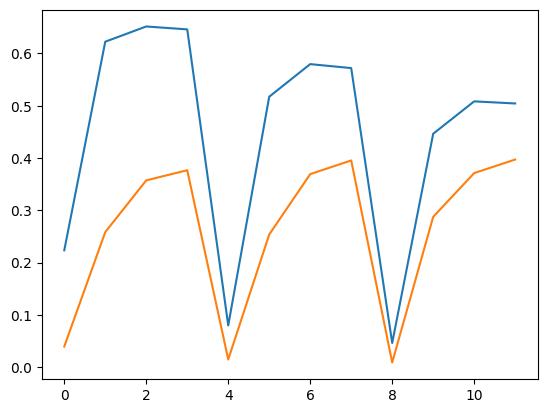

In [11]:
plt.plot(results['mean_train_score'].values)
plt.plot(results['mean_test_score'].values)

In [12]:
#perform gridsearch with accuracy as metric
grid_search = GridSearchCV(
    full_pipeline, param_grid, cv=3, verbose=1, n_jobs=2, scoring='accuracy',
    return_train_score=True)

#grid_search.fit(x_train, y_train)
grid_search.fit(train_data, train_labels.values.ravel())

print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))
#print('all the cv scores')
results = pd.DataFrame(grid_search.cv_results_)
print('Mean Train Accuracy:')
print(results['mean_train_score'])
print('Mean Validation Accuracy:')
print(results['mean_test_score'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
best score 0.726990279671265
best score {'classifier__eta': 0.05, 'classifier__scale_pos_weight': 1}
Mean Train Accuracy:
0     0.762293
1     0.819629
2     0.768152
3     0.732598
4     0.739760
5     0.777266
6     0.711918
7     0.659940
8     0.734752
9     0.732098
10    0.656334
11    0.588632
Name: mean_train_score, dtype: float64
Mean Validation Accuracy:
0     0.720781
1     0.665799
2     0.579871
3     0.535503
4     0.726990
5     0.669303
6     0.577366
7     0.522484
8     0.726189
9     0.660891
10    0.560742
11    0.502354
Name: mean_test_score, dtype: float64


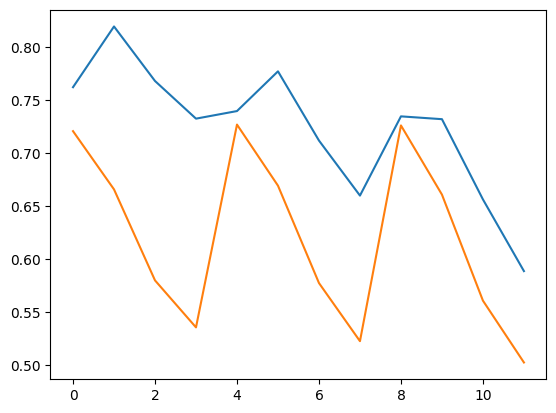

In [13]:
plt.plot(results['mean_train_score'].values)
plt.plot(results['mean_test_score'].values)

In [14]:
pd.DataFrame(grid_search.cv_results_)


#---------FINAL MODEL TESTING-----------

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__eta,param_classifier__scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.205883,0.013594,0.006662,0.000134,0.1,1,"{'classifier__eta': 0.1, 'classifier__scale_po...",0.722439,0.720252,0.719651,0.720781,0.001198,3,0.763221,0.759501,0.764158,0.762293,0.002011
1,0.198601,0.005550,0.006611,0.000290,0.1,2,"{'classifier__eta': 0.1, 'classifier__scale_po...",0.661760,0.670974,0.664663,0.665799,0.003846,5,0.810397,0.828151,0.820339,0.819629,0.007266
2,0.194268,0.000333,0.006633,0.000124,0.1,2.7,"{'classifier__eta': 0.1, 'classifier__scale_po...",0.571944,0.580228,0.587440,0.579871,0.006331,7,0.765475,0.766562,0.772420,0.768152,0.003050
3,0.204836,0.005867,0.006768,0.000374,0.1,3,"{'classifier__eta': 0.1, 'classifier__scale_po...",0.534695,0.535457,0.536358,0.535503,0.000680,10,0.713492,0.739673,0.744630,0.732598,0.013661
4,0.197945,0.003754,0.006758,0.000062,0.05,1,"{'classifier__eta': 0.05, 'classifier__scale_p...",0.729048,0.726863,0.725060,0.726990,0.001630,1,0.738431,0.735917,0.744930,0.739760,0.003798
5,0.202110,0.001368,0.006796,0.000215,0.05,2,"{'classifier__eta': 0.05, 'classifier__scale_p...",0.674677,0.668570,0.664663,0.669303,0.004121,4,0.772987,0.781133,0.777678,0.777266,0.003338
6,0.202634,0.000102,0.006701,0.000136,0.05,2.7,"{'classifier__eta': 0.05, 'classifier__scale_p...",0.573445,0.571214,0.587440,0.577366,0.007181,8,0.717097,0.697612,0.721046,0.711918,0.010244
7,0.202506,0.001312,0.006696,0.000417,0.05,3,"{'classifier__eta': 0.05, 'classifier__scale_p...",0.520877,0.509315,0.537260,0.522484,0.011465,11,0.658203,0.643082,0.678534,0.659940,0.014525
8,0.216853,0.004156,0.006756,0.000180,0.01,1,"{'classifier__eta': 0.01, 'classifier__scale_p...",0.728447,0.727464,0.722656,0.726189,0.002530,2,0.734075,0.732612,0.737569,0.734752,0.002080
9,0.225689,0.002977,0.006666,0.000302,0.01,2,"{'classifier__eta': 0.01, 'classifier__scale_p...",0.666567,0.662560,0.653546,0.660891,0.005445,6,0.733774,0.729007,0.733514,0.732098,0.002188


In [15]:
#all features are numeric
numeric_features = ['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak']

#replace missing values with median and standardize features
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='median')),
       ('scaler', StandardScaler())
])

#preprocessor contains numeric transformer
preprocessor = ColumnTransformer(
    transformers=[ ('numeric', numeric_transformer, numeric_features)]
) 

#clf = DecisionTreeClassifier(max_depth=10)
#clf = SVC(kernel='sigmoid', class_weight={0:1,1:2})
xgb_clf = XGBClassifier(booster='gbtree', 
                        n_estimators=100,
                        eta=0.05, 
                        scale_pos_weight=2.7,
                        subsample=0.5,
                        early_stopping_rounds=5
                        #gamma=5
                        #min_child_weight=20
                        )


# Data preprocessing pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Transform the data
x_train_clean = my_pipeline.fit_transform(x_train)
x_val_clean = my_pipeline.transform(x_val)

# Fit the model
xgb_clf.fit(x_train_clean, y_train, 
          #early_stopping_rounds=5, 
          eval_set=[(x_train_clean, y_train),(x_val_clean, y_val)], 
          verbose=1)

[0]	validation_0-logloss:0.69076	validation_1-logloss:0.69230
[1]	validation_0-logloss:0.68844	validation_1-logloss:0.69131
[2]	validation_0-logloss:0.68519	validation_1-logloss:0.68951
[3]	validation_0-logloss:0.68328	validation_1-logloss:0.68888
[4]	validation_0-logloss:0.68119	validation_1-logloss:0.68787
[5]	validation_0-logloss:0.67944	validation_1-logloss:0.68737
[6]	validation_0-logloss:0.67707	validation_1-logloss:0.68629
[7]	validation_0-logloss:0.67516	validation_1-logloss:0.68557
[8]	validation_0-logloss:0.67262	validation_1-logloss:0.68451
[9]	validation_0-logloss:0.67143	validation_1-logloss:0.68426
[10]	validation_0-logloss:0.66986	validation_1-logloss:0.68390
[11]	validation_0-logloss:0.66774	validation_1-logloss:0.68349
[12]	validation_0-logloss:0.66616	validation_1-logloss:0.68258
[13]	validation_0-logloss:0.66455	validation_1-logloss:0.68197
[14]	validation_0-logloss:0.66264	validation_1-logloss:0.68131
[15]	validation_0-logloss:0.66085	validation_1-logloss:0.68054
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False, eta=0.05,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0500000007,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [16]:
# retrieve performance metrics
results = xgb_clf.evals_result()

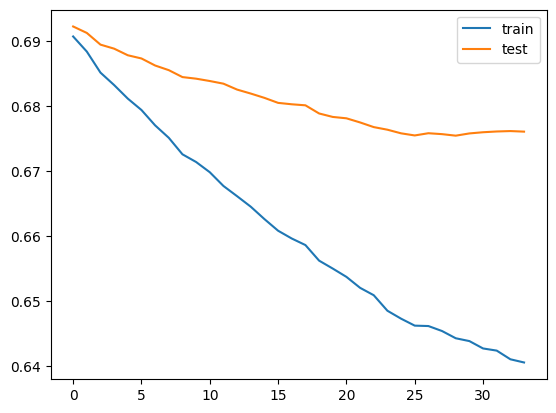

In [17]:
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [18]:
#train prediction scores
y_train_pred = xgb_clf.predict(x_train_clean)
train_acc = accuracy_score(y_train, y_train_pred)
print('Train Accuracy:')
print(train_acc)
print('Train F1 Score:')
print(f1_score(y_train, y_train_pred))
print('Number of positive class predictions:')
print(sum(y_train_pred))
#validation prediction scores
y_val_pred = xgb_clf.predict(x_val_clean)
val_acc = accuracy_score(y_val, y_val_pred)
print('Validation Accuracy:')
print(val_acc)
print('Validation F1 Score:')
print(f1_score(y_val, y_val_pred))
print('Number of positive class predictions:')
print(sum(y_val_pred))

Train Accuracy:
0.6597510373443983
Train F1 Score:
0.5076604554865425
Number of positive class predictions:
2938
Validation Accuracy:
0.5807743658210948
Validation F1 Score:
0.3824975417895772
Number of positive class predictions:
1216


In [19]:
confusion_matrix(y_train, y_train_pred)

array([[3385, 1712],
       [ 666, 1226]])

In [20]:
confusion_matrix(y_val, y_val_pred)

array([[1351,  827],
       [ 429,  389]])

Text(0.5, 0, 'Xgboost Feature Importance')

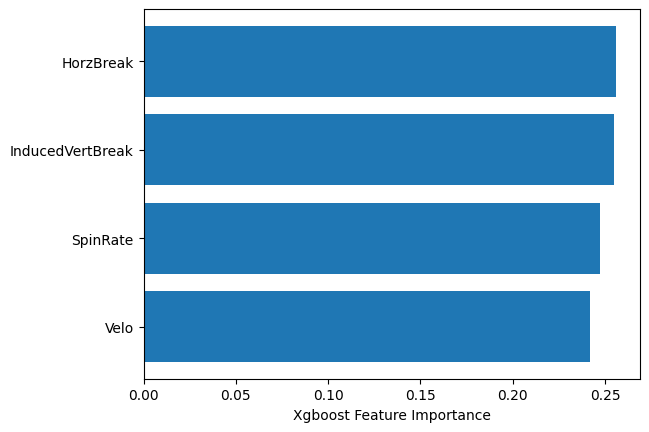

In [21]:
#get feature importances
sorted_idx = xgb_clf.feature_importances_.argsort()
plt.barh(train_data.columns[sorted_idx], xgb_clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")